# Project Overview

E-commerce sites such as Shopee receive multiple product listings daily. To improve recommendations for both retailers and customers, there is a need to identify listings which represent identical products.

Two different images of similar wares may represent the same product or two completely different items. Retailers want to avoid misrepresentations and other issues that could come from conflating two dissimilar products. Currently, a combination of deep learning and traditional machine learning analyzes image and text information to compare similarity. But major differences in images, titles, and product descriptions prevent these methods from being entirely effective.

Note: This project was adapted from a Kaggle competition ([LINK](https://www.kaggle.com/competitions/shopee-product-matching/overview)).

## Project Goal

This project aims to create a model that can determine which products are the same based on their product images. Model performance will be evaluated via mean F1 score.

## Method
The issue presented falls under the similarity learning paradigm. We will first use image perceptual hash(phash) to establish a base model. Images with small phash differences will be considered as the same products.

Next we will use pre-trained Convolutionary Neural Networks(CNN) to convert the images into features. Images which are close together in the feature space will be grouped together and considered as the same products.

**Base Model**<br/>
A base model will first be obtained using the perceptual hash (phash) of the images. Images can be converted into a phash object that can be represented as a 64-bit integer, which can be comparable to another phash via their hamming distance. 

**Convolutionary Neural Network**<br/>
Pre-trained Convolutionary Neural Networks(CNN) will be used to produce embeddings which will be used as features. The metric distances between images will be calculated using the extracted features, and those which are within a certain distance threshold will be classified as the same product.

Fine Tuning will be performed on the CNN to train the model to extract features that are more typical in the dataset.


### Notebooks
1) Exloratory Data Analysis (You are Here!)
2) Training and Modelling 


### Exploratory Data Analysis
Explore the type of images in the dataset and the distribution of classes.

1. [Distribution of classes](#Distribution-of-label-groups)
2. [Distribution of image dimensions](#Distribution-of-image-dimensions)
3. [View Images](#Preliminary-look-at-images)



In [1]:
# Import Datasets
import pandas as pd
import numpy as np
import cv2
import seaborn as sns

from PIL import Image
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from dask import bag, diagnostics

In [2]:
# View data information

train = pd.read_csv('./data/train.csv')

print(train.shape)
train.info()

(34250, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34250 entries, 0 to 34249
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   posting_id   34250 non-null  object
 1   image        34250 non-null  object
 2   image_phash  34250 non-null  object
 3   title        34250 non-null  object
 4   label_group  34250 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.3+ MB


In [3]:
train.head()

,posting_id,image,image_phash,title,label_group
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,4093212188
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,3648931069


## Distribution of label groups

In [4]:
# Get number of products and number of classes

print(f"There are {train.shape[0]} products in the dataset with\
 {train['label_group'].nunique()} distinct groups.")

There are 34250 products in the dataset with 11014 distinct groups.


In [5]:
# Create table of products with counts of a each label

image_groups = train['label_group'].value_counts()
image_groups = pd.DataFrame(image_groups)

image_groups = image_groups.reset_index()

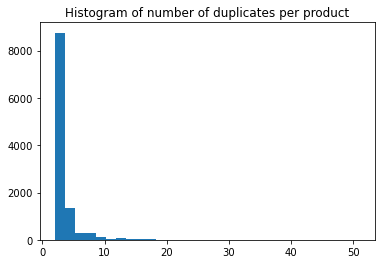

In [6]:
# View distribution of Number of products in the same class

plt.hist(image_groups['label_group'], bins=30)
plt.title("Histogram of number of duplicates per product");

In [7]:
# View distribution of Number of products in the same class

image_groups.groupby('label_group')['label_group'].count()

label_group
2     6979
3     1779
4      862
5      468
6      282
7      154
8      118
9       91
10      48
11      38
12      39
13      28
14      19
15      19
16      13
17       9
18       5
19       5
20       6
21       6
22       6
23       4
24       2
25       2
26       1
27       1
30       1
31       2
32       3
33       3
34       3
35       4
36       1
37       1
41       1
45       1
46       2
49       1
51       7
Name: label_group, dtype: int64

In [8]:
# View distribution of Number of products in the same class

image_groups['grouping'] = ["17+" if x > 16 else str(x) for x in image_groups['label_group']]
image_groups.groupby('grouping')['label_group'].count()

grouping
10       48
11       38
12       39
13       28
14       19
15       19
16       13
17+      77
2      6979
3      1779
4       862
5       468
6       282
7       154
8       118
9        91
Name: label_group, dtype: int64

On average there are only about 3 products per group. The distribution of number of products per group is not uniform. A large number of products only have 2 in the same group (i.e. only 1 product in the same group other than itself), and there are groups with up to 51 products in the same group.

## Distribution of image dimensions

In [57]:
# get image dimensions

im_list = 'data/train_images/' + train['image'] # list of image paths

def get_dims(file):
    img = cv2.imread(file)
    h,w = img.shape[:2]
    return h,w

# parallelize
filelist = im_list
dimsbag = bag.from_sequence(filelist).map(get_dims)
with diagnostics.ProgressBar():
    dims = dimsbag.compute()


[########################################] | 100% Completed |  1min 58.3s


In [58]:
# Create dataframe with image dimensions and counts

dim_df = pd.DataFrame(dims, columns=['height', 'width'])
sizes = dim_df.groupby(['height', 'width']).size().reset_index().rename(columns={0:'count'})

sizes['sqrt_count'] =[round(np.sqrt(x)*20) for x in sizes['count']] # Scale the counts to fit into graph

(0.0, 1200.0)

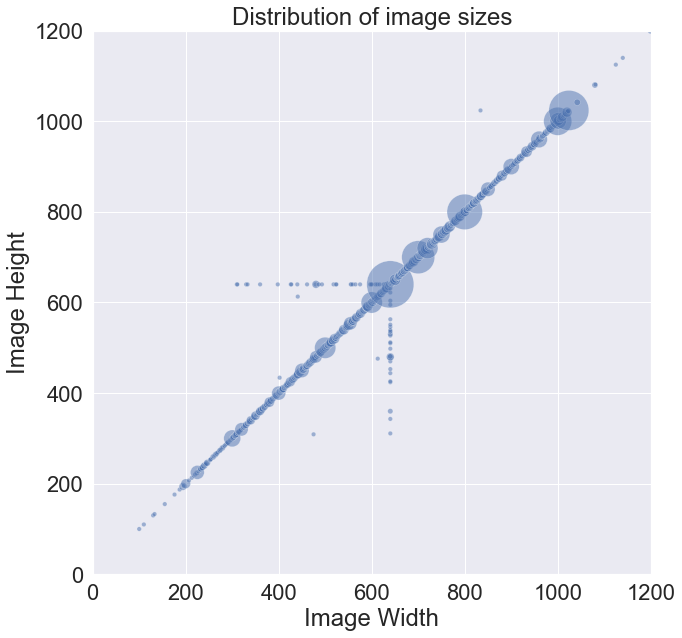

In [61]:
# Plot graph of image dimensions and counts

plt.figure(figsize=(10,10))

p = sns.scatterplot(data = sizes, x = 'height', y = 'width', s=sizes['sqrt_count'],
        sizes=(1, 2), alpha = 0.5,
        )
sns.set_style("whitegrid")
sns.set(font_scale = 2)        
p.set_xlabel("Image Width")
p.set_ylabel("Image Height")

plt.title("Distribution of image sizes")
plt.ylim(0, 1200)
plt.xlim(0, 1200)

In [125]:
# how many square picture?

sqr_pics = sum(dim_df['sqr'] == 1) 

print(f"There are {sqr_pics} square pictures")
print(f"{sqr_pics/34250*100:.2f}% of pictures are square pictures")

There are 34132 square pictures
99.66% of pictures are square pictures


The image sizes are quite varied, however most of them are square shaped. This means that if we were to scale the products to square shapes for analysis, the images will not be very distorted.

## Preliminary look at images

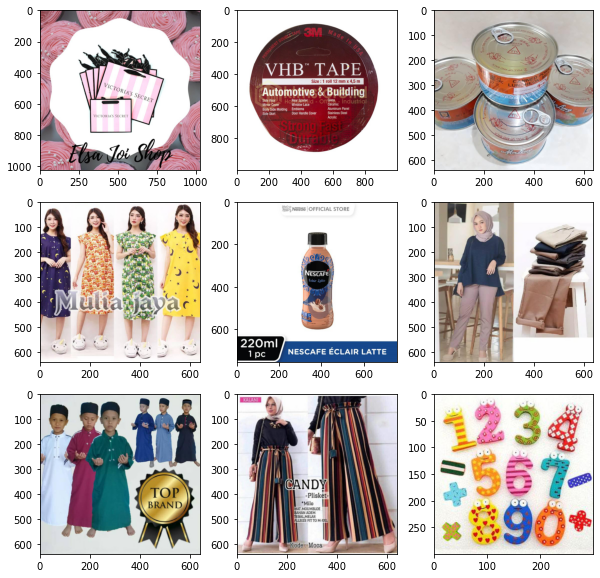

In [9]:
# View first few images
first_nine = train['image'][:9]

plt.figure(figsize=(10,10))

for i in range(9):
    img = mpimg.imread('data/train_images/' + first_nine[i])
    plt.subplot(3,3,i+1)
    plt.imshow(img)


In [11]:
er = image_groups.loc[image_groups['label_group']==2,'index'].values[:3]
ert = train.loc[train['label_group'].isin(er), 'image'].reset_index(drop=True)
ert

0    66c36d75919d3f8bcd719ee41850bfa4.jpg
1    81ca0923bbbdd4a8bd4c36909d104fd9.jpg
2    c15f020b565cc978bf54bd66455c4f39.jpg
3    c2a7cd4b7216dc19b33be4cf4fd312a1.jpg
4    c3a1e1481cbf6907763ce8c53d7c656e.jpg
5    f7879c0811d7145e2866fdcef7014290.jpg
Name: image, dtype: object

In [46]:
# View similar images


def view_images(num_in_group, index):

    # Similar set 1 (2 similar products)
    label = image_groups.loc[image_groups['label_group']==num_in_group,'index'].values[index:index+5]
    label_images = train.loc[train['label_group'].isin(label), ['image', 'label_group']]
    label_images = list(label_images.sort_values('label_group')['image'])

    plt.figure(figsize=(10,10))

    for i in range(9):
        img = mpimg.imread('data/train_images/' + label_images[i])
        plt.subplot(4,3,i+1)
        plt.axis('off')
        plt.imshow(img)

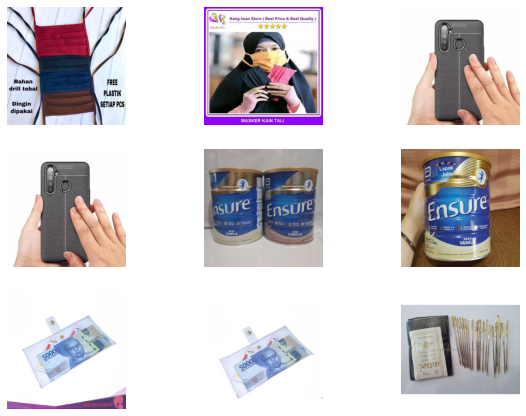

In [47]:
# View group with 2 similar products

view_images(2, 5)

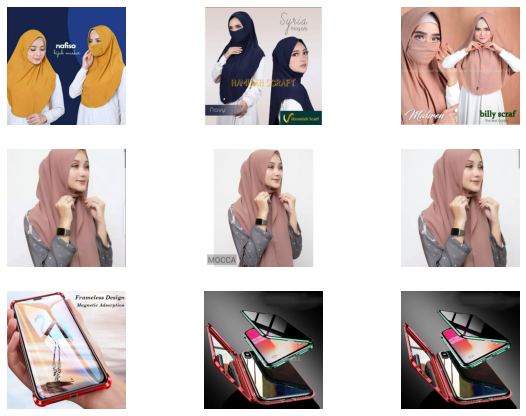

In [48]:
# View group with 3 similar products

view_images(3, 5)

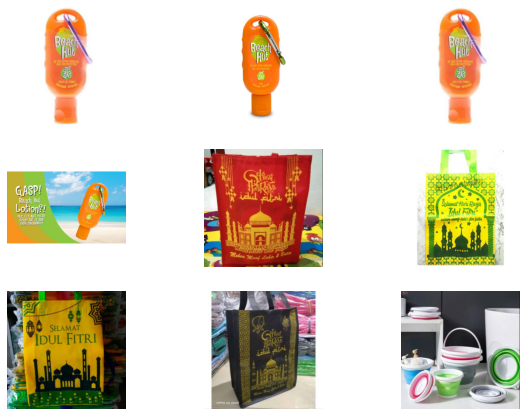

In [52]:
# View group with 4 similar products

view_images(4, 5)

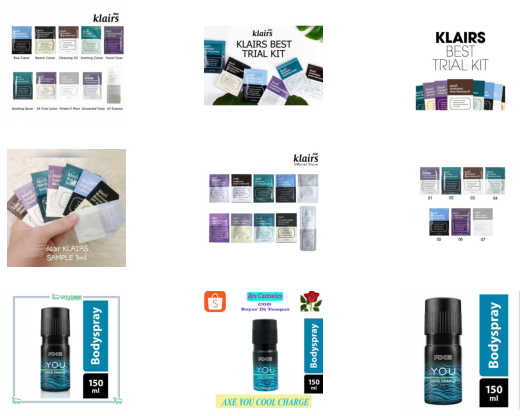

In [51]:
# View group with 6 similar products

view_images(6, 5)

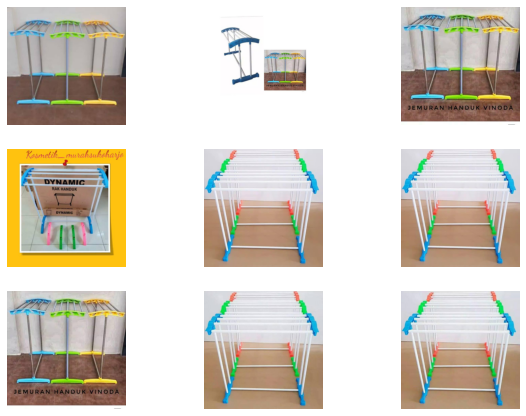

In [54]:
# View group with 9 similar products

view_images(9, 3)

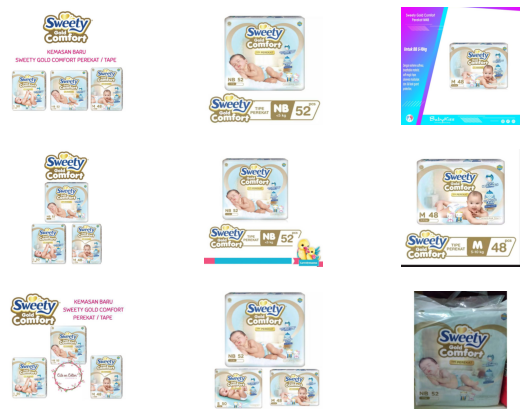

In [55]:
# View group with 12 similar products

view_images(12, 4)

Products in the same category can look identical, have minor differences or look entirely different. We will not expect to pick out those which are entirely different.

**Key Takeaways**

1) Number of products in each group vary greatly. Most of them only have 1 or 2 duplicates in the dataset.
2) Product images are mostly square-sized (More than 99%). Reading them into models with square dimensions will not distort most images.
3) Products in the same category vary greatly in image similarity. We will not expect to to accurately predict all of them.